# 1. 라이브러리 임포트

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. 데이터셋 준비 및 전처리

In [2]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print(ds_info.features)
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [3]:
def normalize_and_resize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

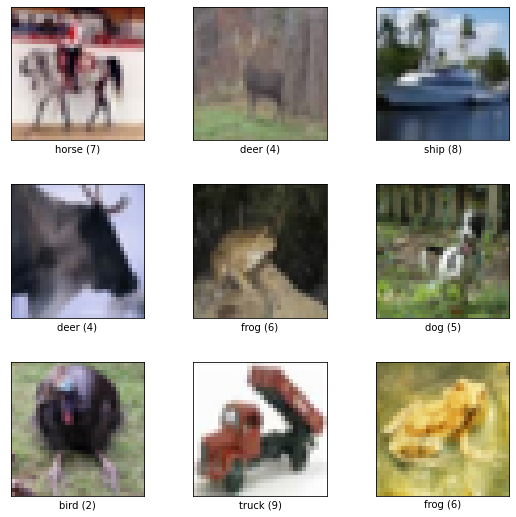

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

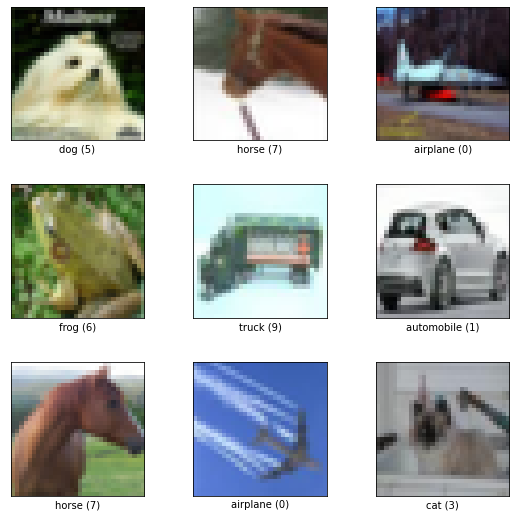

In [5]:
fig = tfds.show_examples(ds_test, ds_info)

In [6]:
BATCH_SIZE = 256
EPOCH = 20

In [7]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

# 3. 모델 블록 및 신경망 정의

In [8]:
def build_first_block(input_layer,stage,channel):
    output = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        strides=(2,2),
        kernel_initializer="he_normal",
        padding="same",
        name=f'stage{stage}_1_conv1'
    )(input_layer)
    output = keras.layers.BatchNormalization(name=f'stage{stage}_1_bn1')(output)
    output = keras.layers.Activation("relu")(output)
    output = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        kernel_initializer="he_normal",
        padding="same",
        name=f'stage{stage}_1_conv2'
    )(output)
    short = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        strides=(2,2),
        kernel_initializer="he_normal",
        padding="same",
        name=f'stage{stage}_1_short'
    )(input_layer)
    output = keras.layers.BatchNormalization(name=f'stage{stage}_1_bn2')(output)
    short = keras.layers.BatchNormalization(name=f'stage{stage}_1_bn4')(short)
    output = keras.layers.Add(name=f'stage{stage}_1_add')([output, short])
    output = keras.layers.Activation("relu")(output)
    return output

def build_resnet_layer(input_layer,
                      is_second=False,
                      stage=1,
                      num_cnn_list=[2, 2, 2],
                      channel_list=[64, 64, 64]):
    output = input_layer
    if is_second:
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            output = build_residual_block(
                output,
                stage=stage,
                num_cnn=num_cnn,
                channel=channel,
                block_num=i
            )
    else:
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            #if first block
            if i == 0:
                output = build_first_block(input_layer, stage, channel)
            else:
                output = build_residual_block(
                    output,
                    stage=stage,
                    num_cnn=num_cnn,
                    channel=channel,
                    block_num=i
                )
    return output
    

def build_residual_block(input_layer,
                        stage=1,
                        num_cnn=2,
                        channel=64,
                        block_num=1):
    x = input_layer
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            kernel_initializer="he_normal",
            padding="same",
            name=f'stage{stage}_{block_num+1}_conv{cnn_num+1}'
        )(x)
        x = keras.layers.BatchNormalization(name=f'stage{stage}_{block_num+1}_bn{cnn_num+1}')(x)
        if cnn_num != (num_cnn - 1):
            x = keras.layers.Activation("relu")(x)
    x = keras.layers.add([input_layer, x], name=f'stage{stage}_{block_num+1}_add')
    x = keras.layers.Activation("relu")(x)
    return x


In [9]:
def build_resnet(input_shape=(32, 32, 3), num_classes=10):
    input_layer = keras.layers.Input(shape=input_shape)
    output = keras.layers.Conv2D(filters=64,
                        kernel_size=(7, 7),
                        strides=(2, 2),
                       padding="same")(input_layer)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation("relu")(output)
    output = keras.layers.MaxPooling2D()(output)
    output = build_resnet_layer(output,
                                is_second=True,
                                stage=2,
                                num_cnn_list=[2, 2, 2],
                                channel_list=[64, 64, 64])
    output = build_resnet_layer(output,
                                stage=3,
                                num_cnn_list=[2, 2, 2, 2],
                                channel_list=[128, 128, 128, 128])
    output = build_resnet_layer(output,
                                stage=4,
                                num_cnn_list=[2, 2, 2, 2, 2, 2],
                                channel_list=[256, 256, 256, 256, 256, 256])
    output = build_resnet_layer(output,
                                stage=5,
                                num_cnn_list=[2, 2, 2],
                                channel_list=[512, 512, 512])
    output = keras.layers.GlobalAveragePooling2D(name="avg_pool")(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='fc10')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [10]:
resnet_34 = build_resnet()
resnet_34.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

# 4. 학습

In [11]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 27s 136ms/step - loss: 2.3596 - accuracy: 0.2377 - val_loss: 2.5704 - val_accuracy: 0.1079
Epoch 2/20
195/195 [==============================] - 14s 70ms/step - loss: 1.8617 - accuracy: 0.3448 - val_loss: 2.5791 - val_accuracy: 0.1616
Epoch 3/20
195/195 [==============================] - 14s 71ms/step - loss: 1.6078 - accuracy: 0.4271 - val_loss: 1.7700 - val_accuracy: 0.3577
Epoch 4/20
195/195 [==============================] - 14s 71ms/step - loss: 1.4251 - accuracy: 0.4939 - val_loss: 1.7516 - val_accuracy: 0.3942
Epoch 5/20
195/195 [==============================] - 14s 71ms/step - loss: 1.2375 - accuracy: 0.5626 - val_loss: 1.7012 - val_accuracy: 0.4161
Epoch 6/20
195/195 [==============================] - 14s 74ms/step - loss: 1.0761 - accuracy: 0.6243 - val_loss: 1.6758 - val_accuracy: 0.4323
Epoch 7/20
195/195 [==============================] - 15s 75ms/step - loss: 0.8920 - accuracy: 0.7003 - val_loss: 1.8006 - val_accuracy

# 5.  결과 시각화

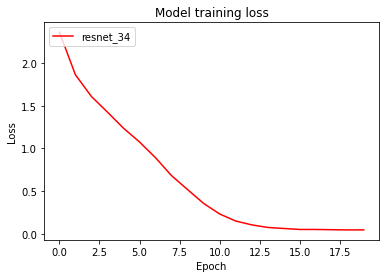

In [12]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34'], loc='upper left')
plt.show()

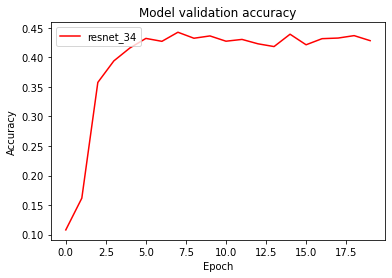

In [13]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34'], loc='upper left')
plt.show()

# 6. 정리
- 시간 관계상 resnet-50은 구현하지 못하였고, resnet-34 모델에 가깝게 구현해보았습니다.
- 하지만 다음 레이어로 넘어가는 사이 구현 부분에 잘못 구현한것 같습니다.
- 훈련을 진행하면서 훈련 정확도는 오르고 비용은 내려갔으나, 검증 비용과 정확도는 증가하다가 다시 주춤하는 모습을 보였습니다.